In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import itertools

Our goal is to create a responsive graph that, when explored in real time, will allow us to obtain information about authors and their publications.

In [6]:
url = 'http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html'

r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')

researchPapers_A = soup.find("a", attrs={"name": "#Research papers"})
researchPapers_h2 = researchPapers_A.find_parent("h2")
ols = researchPapers_A.find_all_next("ol")
researchPapers_OLs = [x for x in ols if x.find_previous("h2") == researchPapers_h2]

As a first step, we want to scrap data on scientific articles. For this purpose, we assign the website address to the variable 'url' to gain access to the data. Then we search the data to find the content we are interested in (including "#Research papers").

In [8]:
authors_dict = {}
authors_weight = {}
for ol in researchPapers_OLs:
    for li in ol.find_all("li"):
        i = li.find("i")
        if i.parent.parent.name == "a":
            fonts = list(i.parent.parent.find_previous_siblings("font"))
            if fonts[0].text.isnumeric():
                fonts = fonts[1:]
        elif i.parent.name == "font":
            fonts = list(i.parent.find_previous_siblings("font"))
            fonts = fonts[1:]
        elif i.parent.name == "li":
            fonts = list(i.find_previous_siblings("font"))
            fonts = fonts[1:]

        authors = [font.text.replace(" ", "") for font in fonts]
        for author in authors:
            authors_weight[author] = authors_weight.get(author, 0) + 1

        for pair in itertools.combinations(authors, 2):
            fset = frozenset(pair) 
            authors_dict[fset] = authors_dict.get(fset, 0) + 1

We create two dictionaries that will be the basis for designing the graph. 'authors_dict' will be used to generate connections and 'authors_weight' to determine nodes weights.

In [9]:
nodes = list(authors_weight.keys())
shuffle(nodes)

In [10]:
nodes_size = [authors_weight[author]*2 for author in nodes] #multiply for bigger scale
nodes_list = [(author, {"publications": authors_weight[author]}) for author in nodes]
edges_list = [(*key, {"weight": weight}) for key, weight in authors_dict.items()]

In [13]:
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)
edges_size = [G[u][v]['weight']//3 + 1 for u,v in G.edges]

m  = max([len(G.edges(node)) for node in nodes])
pos = nx.circular_layout(G)

We structure the graph by setting its shape and properties regarding nodes and weights.

In [ ]:
def update_annot(node_name):
    xy = pos[node_name]
    annot.xy = xy
    node_attr = {'author': node_name}
    node_attr.update(G.nodes[node_name])
    text = '\n'.join(f'{k}: {v}' for k, v in node_attr.items())
    annot.set_text(text)

def color_edges(node_name):
    edges_colors = ["#FF0000" if u==node_name or v == node_name else "#000000" for u, v in G.edges]
    lines.set_colors(edges_colors)

def cooperator_names(node_name):
    for i, (author, cooperator) in enumerate(G.edges(node_name)):
        annots[i].xy = pos[cooperator]
        node_attr = {'author': cooperator, 'cooperations': G[author][cooperator]['weight']}
        annots[i].set_text('\n'.join(f'{k}: {v}' for k, v in node_attr.items()))
        annots[i].set_visible(True)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scatter.contains(event)
        if cont:
            node_name = list(pos)[ind["ind"][0]]
            update_annot(node_name)
            color_edges(node_name)
            cooperator_names(node_name)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                for a in annots:
                    a.set_visible(False)
                fig.canvas.draw_idle()

Our graph will run in real time, it will react to the action performed (in this case - hovering the mouse over the selected node). For the graph to work properly, it is necessary to define the appropriate functions:
- update_annot - displaying annotations for the selected node and nodes connected to it
- color_edges - changes the connection color of the selected node
- cooperator_names - displays details contained in annotations
- hover - controls the responsiveness of the graph by calling the above functions

<IPython.core.display.Javascript object>


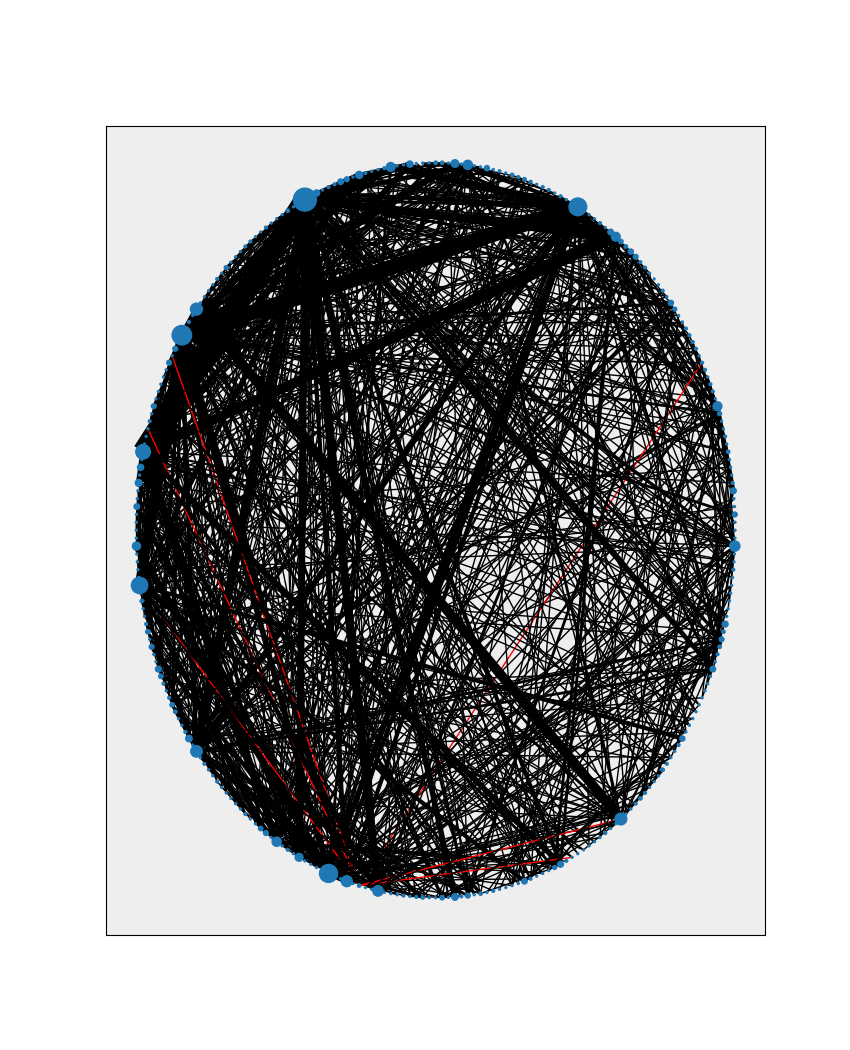

In [14]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))
fig.set_size_inches(8.5, 10.5)
scatter = nx.draw_networkx_nodes(G, pos, node_size=nodes_size, ax=ax)
lines = nx.draw_networkx_edges(G,  pos, width=edges_size, ax=ax)
annot = ax.annotate("", xy=(0,0), xytext=(50,50),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color="#0000FF"))
annot.set_visible(False)

annots = [ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color="#0000FF")) for i in range(m)]
for a in annots:
    a.set_visible(False)

cid = fig.canvas.mpl_connect("motion_notify_event", hover)